# 🎄 Overview 🎄
My first attempt at this problem set used the A-star algorithm (https://www.kaggle.com/code/clehmann10/beginner-s-a-star-algorithm-tutorial). While it was very effective for the puzzles with small state-spaces, it failed to produce any solutions for the more complex puzzles.

This was especially bad since the total score for this challenge is the total number of moves required to solve all puzzles, and some puzzles seem to require 10,000+ moves. Here we're going to try a slightly more aggressive alternative - the Iterative Deepening A-star (IDA-star) algorithm. (https://en.wikipedia.org/wiki/Iterative_deepening_A*#:~:text=Iterative%20deepening%20A*%20)

This algorithm uses the basic A-star algorithm but restarts it at certain intervals, allowing the algorithm to focus less on the state-space near the start of the problem, and progress much closer to the end.

# ⚙️ Setup
Set up the notebook environment

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
import heapq
import random
random.seed(1)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santa-2023/sample_submission.csv
/kaggle/input/santa-2023/puzzles.csv
/kaggle/input/santa-2023/puzzle_info.csv


In [2]:
# Load Data
INPUT_DIR = '/kaggle/input/santa-2023'
puzzles_df = pd.read_csv(f'{INPUT_DIR}/puzzles.csv')
puzzle_info_df = pd.read_csv(f'{INPUT_DIR}/puzzle_info.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
df_dict = {
    "Puzzles": puzzles_df,
    "Puzzle Info": puzzle_info_df,
    "Sample submission": ss_df,
}

# 🔎 Examine the Data
Let's take another look at the sample submission to see what we're working with and plan a strategy for how to achieve the best score.

In [3]:
# Split up the initial state 
puzzles_df['initial_state_parsed'] = puzzles_df['initial_state'].apply(lambda x: x.split(";"))
# Split up the solution state 
puzzles_df['solution_state_parsed'] = puzzles_df['solution_state'].apply(lambda x: x.split(";"))
# Get total number of 'faces' to be solved
puzzles_df['total_components'] = puzzles_df['solution_state_parsed'].apply(lambda x: len(x))
# Get a list of 'colours'
puzzles_df['unique_components'] = puzzles_df['solution_state_parsed'].apply(lambda x: np.unique(x))
# How many 'colours' are there?
puzzles_df['total_unique_components'] = puzzles_df['unique_components'].apply(lambda x: len(x))

# Convert allowed moves from string to dict
import json
def get_allowed_moves(dict_string):
    moves_dict = json.loads(dict_string.replace("'", '"'))
    # add inverse moves
    for move in list(moves_dict.keys()):
        inverse_move = list(np.argsort(moves_dict[move]))
        if inverse_move not in moves_dict.values():
            moves_dict['-' + move] = inverse_move
    return moves_dict
puzzle_info_df['allowed_moves_dict'] = puzzle_info_df['allowed_moves'].apply(lambda x: get_allowed_moves(x))
# Get total number of allowed moves
puzzle_info_df['total_allowed_moves'] = puzzle_info_df['allowed_moves_dict'].apply(lambda x: len(x.keys()))

# Split up sample submission into list
ss_df['moves_parsed'] = ss_df['moves'].apply(lambda x: x.split('.'))
# Count moves in sample submission solutions
ss_df['total_moves'] = ss_df['moves_parsed'].apply(lambda x: len(x))

In [4]:
# Print out an exerpt from each of the dataframes we've been given
for df_key in df_dict.keys():
    print(f"- {df_key} -\nShape: {df_dict[df_key].shape} - {df_dict[df_key].shape[0]} Rows x {df_dict[df_key].shape[1]} Columns\nFeatures: {df_dict[df_key].columns.values}\n")
    print(df_dict[df_key].head(10))
    print('─'*70)

- Puzzles -
Shape: (398, 10) - 398 Rows x 10 Columns
Features: ['id' 'puzzle_type' 'solution_state' 'initial_state' 'num_wildcards'
 'initial_state_parsed' 'solution_state_parsed' 'total_components'
 'unique_components' 'total_unique_components']

   id puzzle_type                                   solution_state  \
0   0  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
1   1  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
2   2  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
3   3  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
4   4  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
5   5  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
6   6  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
7   7  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
8   8  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
9   9  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E

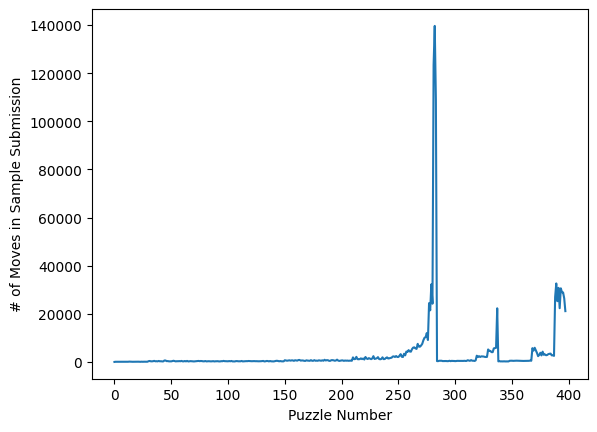

In [5]:
plt.plot(ss_df['total_moves'])
ss_df.sort_values(by='total_moves', ascending=False).head(20)
plt.xlabel("Puzzle Number")
plt.ylabel("# of Moves in Sample Submission")
plt.show()

In [6]:
ss_df = ss_df.sort_values(by='total_moves', ascending=False)
print(f"{sum(ss_df['total_moves'].iloc[0:2])} / {sum(ss_df['total_moves'])} = {100*sum(ss_df['total_moves'].iloc[0:2])/sum(ss_df['total_moves']):.4f}% of moves come from the top 3 puzzles")
ss_df.head(20)


263060 / 1220590 = 21.5519% of moves come from the top 3 puzzles


,id,moves,moves_parsed,total_moves
282,282,f7.-d1.r3.r25.-r2.r12.-f1.-r4.f25.r28.d7.f3.d8...,"[f7, -d1, r3, r25, -r2, r12, -f1, -r4, f25, r2...",139629
281,281,f23.-f29.d4.-f24.-f4.f25.-f14.-f25.f4.f15.r0.-...,"[f23, -f29, d4, -f24, -f4, f25, -f14, -f25, f4...",123431
283,283,f11.-d15.-r13.d0.-f0.f11.-r12.r29.-d4.-r28.-r2...,"[f11, -d15, -r13, d0, -f0, f11, -r12, r29, -d4...",109140
389,389,f51.f11.-f1.-f42.f47.f10.-f49.-r3.-f51.f11.-f1...,"[f51, f11, -f1, -f42, f47, f10, -f49, -r3, -f5...",32610
279,279,d15.r16.f4.-f0.f18.-d6.-r3.-r14.f5.-d15.f9.f18...,"[d15, r16, f4, -f0, f18, -d6, -r3, -r14, f5, -...",32249
391,391,f40.f19.-f9.-f20.f16.-f5.-f45.f52.f4.-f30.-f47...,"[f40, f19, -f9, -f20, f16, -f5, -f45, f52, f4,...",30775
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...,"[f19, f21, -f39, f20, f2, -f5, f7, -r3, f55, -...",30596
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...,"[-f31, -f22, f16, -f17, -f13, -f24, -f14, f2, ...",28971
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....,"[-r0, -f42, -f8, f16, -f49, f14, -f1, f56, f26...",28876
388,388,-f14.f23.-r1.f10.-f22.-f43.f4.f38.f22.f52.-f14...,"[-f14, f23, -r1, f10, -f22, -f43, f4, f38, f22...",26960


In [7]:
puzzle_info_df.head(200)

,puzzle_type,allowed_moves,allowed_moves_dict,total_allowed_moves
0,cube_2/2/2,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...","{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...",12
1,cube_3/3/3,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...","{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...",18
2,cube_4/4/4,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",24
3,cube_5/5/5,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",30
4,cube_6/6/6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",36
5,cube_7/7/7,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",42
6,cube_8/8/8,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",48
7,cube_9/9/9,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",54
8,cube_10/10/10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",60
9,cube_19/19/19,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",114


This shows 21% of the total score accumulation comes from 3 of the 398 problems. By better targetting these bigger problems we'll be able to gain a huge improvement to our score.

# ⚒️ Operations
Here we outline the functions which will be our basic operations.

In [8]:
def apply_move(state, move):
    # The move vector tells us what index to sample the next state from
    return [state[i] for i in move]

def apply_move_sequence(state, move_sequence, move_dict):
    # Apply a series of moves when given them as a string
    new_state = state
    for move_str in move_sequence.split('.'):
        move = move_dict.get(move_str)
        new_state = apply_move(new_state, move)
    return new_state
        

# ⤵️ Iterative Deepening A* Algorithm
One of the problems with the basic A-star algorithm is that it's not very 'aggressive'. It very carefully explores the state-space near the starting location and as a result for many of the puzzles it never finds a solution.

By using Iterative Deepening A-star (IDA-star), we use the same algorithm but end it and restart it repeatedly. After each iteration we take the best state/path from what we have available and treat that as a new start point. This way we don't spend most of our time nearby the initial state but instead move 'deeper' into the state-space and closer to a solution.

One problem I came across here is that when we start a new iteration a failure occurs because the closed_set (the set of states which we've already visited and so want to avoid) completely occupies all the possible moves. A solution of this was to downsample the closed_set every time we start a new iteration. This way we still avoid and spend less time following the same paths, but are less likely to block ourselves in.

In [9]:
def get_weighting(puzzle_type):
    if 'cube' in puzzle_type:
        geometry = 'cube'
        dimensions = puzzle_type[5:]
        size = dimensions.split("/")[0]
        print(f"Geometry: {geometry}, Dimensions: {dimensions}, Size: {size}")
    elif 'wreath' in puzzle_type:
        geometry = 'wreath'
        dimensions = puzzle_type[5:]
        size = dimensions.split("/")[0]
        print(f"Geometry: {geometry}, Dimensions: {dimensions}, Size: {size}")
    elif 'globe' in puzzle_type:
        geometry = 'globe'
        dimensions = puzzle_type[5:]
        size = dimensions.split("/")[0]
        print(f"Geometry: {geometry}, Dimensions: {dimensions}, Size: {size}")
get_weighting('cube_19/19/19')

def evaluate_weighted_state(current_state, final_state, weighting):
    return sum(map(lambda x, y, w: (x != y)*w, current_state, final_state, weighting))

Geometry: cube, Dimensions: 19/19/19, Size: 19


In [10]:
def evaluate_difference(current_state, final_state):
    return (max(0, sum(s != g for s, g in zip(current_state, final_state))))

def evaluate_score(current_state, final_state):
    # Reward having the final position match, and also reward having 2 of the same state adjacent to each other
    # This has to be fast since it's called so often
    return (max(0, sum(s != g for s, g in zip(current_state, final_state))) + sum(s != g for s, g in zip(current_state[1:], current_state[:-1])) + 0.5*sum(s != g for s, g in zip(current_state[2:], current_state[:-2])))


def idastar(move_dict, initial_state, final_state, params):
    # Priority queue to store nodes with their f-values (g + h)
    puzzle_start_time = time.time()
    iteration_counter = 0
    current_starting_state = initial_state
    current_path = []
    closed_set = set()

    while time.time() - puzzle_start_time < params['max_overall_time'] and iteration_counter < params['max_overall_iterations']:
        
        iteration_counter += 1
        
        # Set the cutoff to be a fraction of the intial start cost
        new_state, new_path, node_counter = depth_limited_search(move_dict, current_starting_state, final_state, closed_set, params)
        
        if new_state is None:
            print("Depth limited search failed. Using sample submission results instead.")
            return None, iteration_counter
        
        current_path += new_path
        current_difference = evaluate_difference(new_state, final_state)
        current_score = evaluate_score(new_state, final_state)
        # Remove every 2nd item from the closed set, so that 
        closed_set = set(random.sample(list(closed_set), int(len(closed_set)*params['set_downsampling'])))
        print(f"Iteration #{iteration_counter} completed - New Moves: {len(new_path)}, Total Moves: {len(current_path)}, Difference: {current_difference}, Score: {current_score}, Nodes: {node_counter}")
        
        if current_difference <= params['wildcards']:
            # We've achieved our goal. Return the move path.
            return current_path, iteration_counter
    print(f"Max search time/iterations expired: {time.time() - puzzle_start_time} seconds, {iteration_counter} iterations.")
    return None, iteration_counter
        

def depth_limited_search(move_dict, initial_state, final_state, closed_set, params):
    # Priority queue to store nodes with their f-values (g + h)
    start_time = time.time()
    open_set = []
    node_counter = 1
    
    heapq.heappush(open_set, (0, initial_state, []))  # (priority, state, path)
    # Set to keep track of visited nodes

    while open_set:
        
        # Get the node with the lowest f-value
        current_f, current_state, current_path = heapq.heappop(open_set)
        
        # Check for timeout
        if time.time() - start_time > params['max_iteration_time']:
#             print("Iteration Timed Out.")
            return current_state, current_path, node_counter
        
        if node_counter > params['max_iteration_nodes']:
#             print("Iteration Node Limit Reached.")
            return current_state, current_path, node_counter

        if evaluate_difference(current_state, final_state) <= params['wildcards']:
            # We've achieved our goal. Return the move path.
            return current_state, current_path, node_counter

        closed_set.add(tuple(current_state))
        
        for move_str, move in move_dict.items():
            new_state = apply_move(current_state, move)
            if tuple(new_state) not in closed_set:
                heapq.heappush(open_set, (len(current_path) + 1 + evaluate_score(new_state, final_state), new_state, current_path + [move_str]))
                node_counter += 1
    # If no solutions are found:
    print("Open set completed. No solutions.")
    return None, None, node_counter

# Test using the sample submission solution for a certain puzzle number
puzzle_number = 1
move_sequence = ss_df.moves_parsed.iloc[puzzle_number]
initial_state = puzzles_df.initial_state_parsed.iloc[puzzle_number]
final_state = puzzles_df.solution_state_parsed.iloc[puzzle_number]
puzzle_type = puzzles_df.puzzle_type.iloc[puzzle_number]
wildcards = puzzles_df.num_wildcards.iloc[puzzle_number]
move_dict = puzzle_info_df.loc[puzzle_info_df['puzzle_type'] == puzzle_type]['allowed_moves_dict'].iloc[0]
ss_moves = len(ss_df[ss_df['id'] == puzzle_number]['moves'].iloc[0])
params = {
    'wildcards': wildcards,
    'max_iteration_time': 30,
    'max_iteration_nodes': 300000,
    'max_overall_time': 240,
    'max_overall_iterations': 50,
    'max_moves': ss_moves,
    'set_downsampling': 0.8
}
print(f"Starting testing with parameters: {params}")
solution_path, iteration_counter = idastar(move_dict, initial_state, final_state, params)
if solution_path is not None:
    print(f"Testing - Puzzle #{puzzle_number} solved in {len(solution_path)} moves. {solution_path}.")
else:
    print(f"Testing - Puzzle #{puzzle_number} not solved.")

Starting testing with parameters: {'wildcards': 0, 'max_iteration_time': 30, 'max_iteration_nodes': 300000, 'max_overall_time': 240, 'max_overall_iterations': 50, 'max_moves': 227, 'set_downsampling': 0.8}
Iteration #1 completed - New Moves: 13, Total Moves: 13, Difference: 0, Score: 10.0, Nodes: 38359
Testing - Puzzle #1 solved in 13 moves. ['f1', '-d0', '-r0', 'f1', 'r0', 'f0', 'd1', '-r0', '-d0', 'f0', 'f0', 'd0', '-f0'].


In [11]:
# Puzzle solver automated
def solve_puzzles(puzzles_df, puzzle_info_df):
    solution_list = []
    for puzzle_number in np.arange(len(puzzles_df)):
        solution_dict = {'id': puzzle_number}
        ss_moves = len(ss_df[ss_df['id'] == puzzle_number]['moves_parsed'].iloc[0])
        if ss_moves > 1500:
            # This problem takes more than 100 moves. Skip it, this is too slow.
            solution_moves = ss_df[ss_df['id'] == puzzle_number]['moves_parsed'].iloc[0]

            print(f"Puzzle #{puzzle_number} skipped since expceted moves is {ss_moves} and we think we'll be too slow. Using sample submission solution instead.")
            continue
        
        puzzle_start_time = time.time()
        move_sequence = ss_df.moves_parsed.iloc[puzzle_number]
        initial_state = puzzles_df.initial_state_parsed.iloc[puzzle_number]
        final_state = puzzles_df.solution_state_parsed.iloc[puzzle_number]
        puzzle_type = puzzles_df.puzzle_type.iloc[puzzle_number]
        wildcards = puzzles_df.num_wildcards.iloc[puzzle_number]
        move_dict = puzzle_info_df.loc[puzzle_info_df['puzzle_type'] == puzzle_type]['allowed_moves_dict'].iloc[0]
        params = {
            'wildcards': wildcards,
            'max_iteration_time': 15,
            'max_iteration_nodes': 250000,
            'max_overall_time': 150,
            'max_overall_iterations': 50,
            'max_moves': ss_moves,
            'set_downsampling': 0.8
        }

        solution_path, iteration_counter = idastar(move_dict, initial_state, final_state, params)
        if solution_path is not None:
            solution_moves = ".".join(solution_path)
            self_solved = True
            print(f"Puzzle #{puzzle_number} solved in {len(solution_path)} moves. {(time.time()-puzzle_start_time):.2f} seconds, {iteration_counter} iterations. {solution_path}")
        else:
            # If no solution found, use the sample submission's result
            solution_moves = ss_df[ss_df['id'] == puzzle_number]['moves'].iloc[0]
            solution_path = ss_df[ss_df['id'] == puzzle_number]['moves_parsed'].iloc[0]
            self_solved = False
            print(f"Puzzle #{puzzle_number} failed after {(time.time()-puzzle_start_time):.2f} seconds, {iteration_counter} iterations. Using sample submission solution instead.")
        solution_dict = {
            'id': puzzle_number,
            'moves': solution_moves,
            'move_total': len(solution_path),
            'ss_moves': ss_moves,
            'self_solved': self_solved,
            'time_taken': time.time()-puzzle_start_time,
            'iteration_counter': iteration_counter,
        }
        solution_list.append(solution_dict)
    solution_df = pd.DataFrame(solution_list)
    return solution_df

solution_df = solve_puzzles(puzzles_df, puzzle_info_df)
solution_df.head(400)

Iteration #1 completed - New Moves: 2, Total Moves: 2, Difference: 0, Score: 10.0, Nodes: 24
Puzzle #0 solved in 2 moves. 0.00 seconds, 1 iterations. ['r1', '-f1']
Iteration #1 completed - New Moves: 13, Total Moves: 13, Difference: 0, Score: 10.0, Nodes: 38359
Puzzle #1 solved in 13 moves. 1.04 seconds, 1 iterations. ['f1', '-d0', '-r0', 'f1', 'r0', 'f0', 'd1', '-r0', '-d0', 'f0', 'f0', 'd0', '-f0']
Iteration #1 completed - New Moves: 14, Total Moves: 14, Difference: 0, Score: 10.0, Nodes: 92753
Puzzle #2 solved in 14 moves. 2.62 seconds, 1 iterations. ['-f1', 'f0', '-r1', '-r1', '-f0', '-r0', '-d0', '-f0', 'd0', 'f0', 'f0', '-d0', '-f0', 'd0']
Iteration #1 completed - New Moves: 14, Total Moves: 14, Difference: 0, Score: 10.0, Nodes: 176509
Puzzle #3 solved in 14 moves. 4.96 seconds, 1 iterations. ['-f0', '-d0', '-f1', 'r0', '-d1', 'r0', 'f1', '-r1', '-d1', 'r1', '-f0', 'r1', 'f0', '-d1']
Iteration #1 completed - New Moves: 14, Total Moves: 14, Difference: 0, Score: 10.0, Nodes: 1061

,id,moves,move_total,ss_moves,self_solved,time_taken,iteration_counter
0,0,r1.-f1,2,2,True,0.001527,1
1,1,f1.-d0.-r0.f1.r0.f0.d1.-r0.-d0.f0.f0.d0.-f0,13,63,True,1.040946,1
2,2,-f1.f0.-r1.-r1.-f0.-r0.-d0.-f0.d0.f0.f0.-d0.-f...,14,62,True,2.619847,1
3,3,-f0.-d0.-f1.r0.-d1.r0.f1.-r1.-d1.r1.-f0.r1.f0.-d1,14,92,True,4.962180,1
4,4,r0.-f0.r1.-f1.d0.r0.r0.-f0.-r0.f0.r0.-f0.-r0.f0,14,70,True,2.829473,1
...,...,...,...,...,...,...,...
292,363,-f3.r3.-r0.-f6.-f5.-r2.-f5.-f6.-r0.f1.r2.f0.f4...,432,432,False,152.876801,19
293,364,-f4.f5.f1.-r3.f1.-f3.-f7.-f5.r2.-f3.-f1.r3.f1....,506,506,False,151.893483,19
294,365,-r2.-f4.-f0.-f0.f3.-f5.-f4.f3.f5.-f1.r2.f0.r2....,463,463,False,153.539729,19
295,366,-f1.-r2.f6.-f7.f4.r2.-f3.-f6.-f7.-r2.-f1.-f0.f...,564,564,False,154.875263,19


In [12]:
# Look over solution
print(f"Total moves: {solution_df['move_total'].sum()}")
print(f"Total sample solution moves: {solution_df['ss_moves'].sum()}")
print(f"Improvement compared to sample solutions: {100-100*solution_df['move_total'].sum()/solution_df['ss_moves'].sum():.2f}%")
print(f"Total solved: {solution_df['self_solved'].sum()}")
print(f"Total time taken: {solution_df['time_taken'].sum()/60:.2f} minutes")

Total moves: 111748
Total sample solution moves: 128814
Improvement compared to sample solutions: 13.25%
Total solved: 65
Total time taken: 596.23 minutes


***
# 📮 Final Submission
Now we just need to convert this dict into a csv matching the sample submission and we're off!
Thanks for following along, comment any questions you have and I'll try to answer!

🎅 Merry christmas and happy new year! 🎅

In [13]:
# Compile into csv
final_solution_df = solution_df[['id', 'moves']]
final_solution_df.to_csv("submission.csv", header=['id', 'moves'], index=False)
print(final_solution_df)

      id                                              moves
0      0                                             r1.-f1
1      1        f1.-d0.-r0.f1.r0.f0.d1.-r0.-d0.f0.f0.d0.-f0
2      2  -f1.f0.-r1.-r1.-f0.-r0.-d0.-f0.d0.f0.f0.-d0.-f...
3      3  -f0.-d0.-f1.r0.-d1.r0.f1.-r1.-d1.r1.-f0.r1.f0.-d1
4      4    r0.-f0.r1.-f1.d0.r0.r0.-f0.-r0.f0.r0.-f0.-r0.f0
..   ...                                                ...
292  363  -f3.r3.-r0.-f6.-f5.-r2.-f5.-f6.-r0.f1.r2.f0.f4...
293  364  -f4.f5.f1.-r3.f1.-f3.-f7.-f5.r2.-f3.-f1.r3.f1....
294  365  -r2.-f4.-f0.-f0.f3.-f5.-f4.f3.f5.-f1.r2.f0.r2....
295  366  -f1.-r2.f6.-f7.f4.r2.-f3.-f6.-f7.-r2.-f1.-f0.f...
296  367  f2.f5.f5.-r1.f6.f2.f0.r0.f3.-f2.-f4.-r2.-f6.-f...

[297 rows x 2 columns]
